In [1]:
import os
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from scipy.stats import gaussian_kde
import seaborn as sns
from scipy.optimize import curve_fit
from matplotlib import pyplot
import numpy as np
from sklearn.linear_model import LinearRegression
import warnings

warnings.filterwarnings('ignore')


In [569]:
def getAllRateInfo(path):
    res=pd.DataFrame()
    files=[x for x in os.listdir(path) if 'RateConst.csv' in x  ]
    # files=[x for x in os.listdir(path) if 'RateConst.csv' in x and 'CPSM_MOUSE.' in x  ]
    # files=[x for x in os.listdir(path) if 'RateConst.csv' in x and 'CH60_MOUSE.' in x  ]
    # files=[x for x in os.listdir(path) if 'RateConst.csv' in x and 'FAS_MOUSE.' in x  ]
    for f in tqdm(files):
        try:
            temp=pd.read_csv(os.path.join(path,f))
            temp=temp.dropna()
            temp['Protein']=f.replace('.RateConst.csv','')
            res=pd.concat([res,temp])
        except Exception as exp:
            print(f,exp)
    res.columns=[x.strip() for x in res.columns]
    return res
def read_n_merge(orignial_data,skip,file,folder_path):
    file_data=pd.read_csv(os.path.join(folder_path,file),skiprows=skip,index_col=False)
    file_data.columns=[x.strip() for x in file_data.columns]
    isparsed=(set(['Peptide', 'UniqueToProtein', 'Exchangeable Hydrogens', 'Charge',
       'm/z(Sequence)', 'M0', 'M1', 'M2', 'M3', 'M4']).issubset(set(file_data.columns)))
    isparsed=isparsed and file_data.shape[0]>0    
    if isparsed:
        file_data['Protein']=file.replace('.Quant.csv','')
        orignial_data=pd.concat([orignial_data,file_data])       
    return [isparsed,orignial_data]

def get_df_all_quant_files(path):
    files=[x for x in os.listdir(path) if '.Quant.csv' in x  ]
    # files=[x for x in os.listdir(path) if 'CPSM_MOUSE.Quant.csv' in x  ] 
    # files=[x for x in os.listdir(path) if 'CH60_MOUSE.Quant.csv' in x  ] 
    # files=[x for x in os.listdir(path) if 'FAS_MOUSE.Quant.csv' in x  ]      
    all_data=pd.DataFrame()  
        
    for index in tqdm(range(len(files))):            
        res=read_n_merge(all_data,1,files[index],path)
        # print(res)
        if res[0]:
            all_data=res[1]
        else:
            all_data=read_n_merge(all_data,3,files[index],path)[1]
    all_data=all_data.reset_index(drop=True)
    all_data.columns=[x.strip() for x in all_data.columns]
    return all_data

In [570]:
path=r"\\UT321319\Shared_Folder\NEH_Dependence\liverpool_liver"
quant=get_df_all_quant_files(path)
rate=getAllRateInfo(path)

100%|██████████| 2010/2010 [02:00<00:00, 16.72it/s]


In [568]:
rate.shape

(18510, 16)

In [573]:
merged=pd.merge(quant,rate,left_on=['Peptide','Charge'],right_on=['Peptides','Charge'])
# merged=merged[merged['Rsquared']>0.9].reset_index(drop=True)
merged=merged.reset_index(drop=True)
quant=merged.copy()

In [574]:
# np.random.random(size=peptides.shape[0],min=0.01,max=0.05)

In [575]:
# peptides.to_csv("peptides.csv",index=False)

In [702]:
ph=1.5574E-4
# k=0.035 
t=21
np.random.seed(25)

In [703]:
peptides=quant[['Peptide', 'Charge','Exchangeable Hydrogens', 
       'm/z(Sequence)_x', 'M0', 'M1', 'M2', 'M3', 'M4', 'M5' ]]
peptides=peptides.drop_duplicates()
peptides.shape

peptides['M0']=peptides['M0']/100
peptides['M1']=peptides['M1']/100
peptides['M2']=peptides['M2']/100
peptides['M3']=peptides['M3']/100
peptides['M4']=peptides['M4']/100
peptides['M5']=peptides['M5']/100
peptides['k']=np.random.uniform(low=0.01, high=0.05, size=peptides.shape[0])


peptides['I0_asymp']= peptides.M0 * (  (1 - (0.015/(1-ph))) ** peptides['Exchangeable Hydrogens'] )
# peptides['I0_t'] =  peptides['I0_asymp'] + ( peptides.M0 - peptides['I0_asymp'])*math.exp(-k*t)
peptides['I0_t'] =  peptides['I0_asymp'] + ( peptides.M0 - peptides['I0_asymp'])*np.exp(-peptides['k']*t)
# peptides['I0_t']  = peptides.M0 - (peptides['k']*t) * ( peptides.M0 - peptides['I0_asymp']) 

# peptides['I0_t_noise']= peptides['I0_t']+np.random.normal(loc=0, scale=1E-3, size=peptides.shape[0])
# peptides['I0_t_noise']= peptides['I0_t']+np.random.normal(loc=0.007744510827742353, scale= 0.008071293486088484, size=peptides.shape[0])
peptides['I0_t_noise']= peptides['I0_t']+np.random.laplace(0.007944016223485617, 0.006262487876779792,peptides.shape[0])


np.random.seed(45)
io_0_noise=np.random.laplace(0.007944016223485617, 0.006262487876779792,peptides.shape[0])
# io_0_noise=np.array([0]*peptides.shape[0]) #
# io_0_noise=peptides['I0_t']+np.random.normal(loc=0.007744510827742353, scale= 0.008071293486088484, size=peptides.shape[0])

peptides['I0_t_rd']= (peptides['I0_t_noise'] - peptides['I0_t']) /peptides['I0_t']
peptides['px_t']= ( 1 -  ( (peptides.I0_t / peptides.M0)** (1/peptides['Exchangeable Hydrogens']) ) )  * (1-ph)
peptides['FSR'] = (peptides.M0 - peptides.I0_t)/ (peptides.M0 - peptides.I0_asymp)
peptides['k_log_apr']= -np.log(1-peptides.FSR)/t
peptides['k_two_samp']= peptides['FSR']/t


peptides['px_t_noise']= ( 1 -  ( (peptides.I0_t_noise / peptides.M0)** (1/peptides['Exchangeable Hydrogens']) ) )  * (1-ph)
peptides['FSR_noise'] = (peptides.M0+io_0_noise - peptides.I0_t_noise)/ (peptides.M0+io_0_noise - peptides.I0_asymp)
peptides['k_log_apr_noise']= -np.log(1-peptides.FSR_noise)/t
peptides['k_two_samp_noise']= peptides['FSR_noise']/t

peptides['I0_t_d']= (peptides.M0+io_0_noise) - peptides['I0_t_noise'] 

peptides.head()


,Peptide,Charge,Exchangeable Hydrogens,m/z(Sequence)_x,M0,M1,M2,M3,M4,M5,...,I0_t_rd,px_t,FSR,k_log_apr,k_two_samp,px_t_noise,FSR_noise,k_log_apr_noise,k_two_samp_noise,I0_t_d
0,NLLSVAYK,2,11,454.26600,0.58030,0.30342,0.09172,0.02031,0.00362,0.00055,...,0.033306,0.008873,0.609725,0.044805,0.029035,0.005917,0.567562,0.039920,0.027027,0.068532
1,EMQPTHPIR,3,21,370.19044,0.50917,0.30906,0.12900,0.04018,0.01005,0.00210,...,-0.036792,0.006980,0.502974,0.033291,0.023951,0.008750,0.641966,0.048911,0.030570,0.094424
2,DSTLIMQLLR,2,16,595.33409,0.48532,0.31604,0.13829,0.04522,0.01191,0.00263,...,0.017608,0.004998,0.358679,0.021154,0.017080,0.003912,0.311719,0.017788,0.014844,0.033855
3,YLSEVASGENK,2,23,598.79330,0.50852,0.32518,0.12269,0.03414,0.00770,0.00148,...,0.015917,0.004093,0.306612,0.017436,0.014601,0.003409,0.238169,0.012954,0.011341,0.034674
4,DSTLImQLLR,2,16,603.33155,0.48532,0.31604,0.13829,0.04522,0.01191,0.00263,...,-0.001621,0.005982,0.426114,0.026444,0.020291,0.006082,0.469628,0.030199,0.022363,0.052349


In [704]:
# plt.hist(peptides.I0_t_noise-peptides.I0_t)
# # plt.scatter(peptides.I0_t,peptides.I0_t_noise,c='k')
# # plt.plot(peptides.I0_t,peptides.I0_t,c='r')

In [705]:
peptides.to_csv("peptides.csv",index=False)

In [706]:
random_numbers = np.random.normal(loc=0, scale=1E-2, size=10)
random_numbers

array([ 1.41048123e-02,  8.27411682e-03, -4.40691992e-03, -1.46040484e-03,
        7.68696350e-05,  8.71226661e-03, -6.11357201e-04,  4.24453247e-04,
       -6.52666713e-03,  5.48903771e-04])

In [707]:
# peptides.iloc[10,:]

In [708]:
# plt.scatter(peptides.k,peptides.k_log_apr_noise)
# plt.scatter(peptides.k,peptides.k_two_samp_noise)

In [709]:
# plt.scatter(peptides.I0_t_rd,
#     abs(peptides.k-peptides.k_log_apr_noise)/peptides.k)

# plt.scatter(peptides.I0_t_rd,
#     abs(peptides.k-peptides.k_two_samp_noise)/peptides.k)

In [710]:
plt.rc("font",size=14)

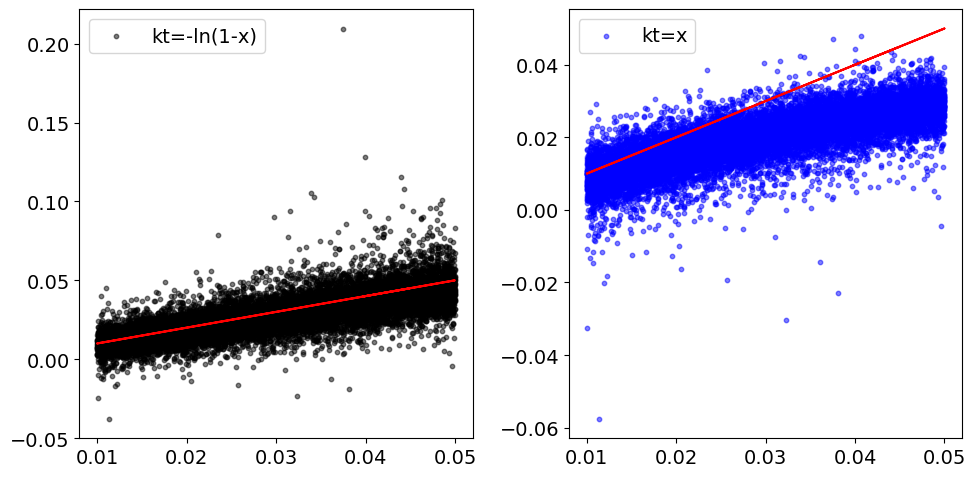

In [711]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(peptides.k,peptides.k_log_apr_noise,label="kt=-ln(1-x)",alpha=0.5,c='k',s=10)
plt.plot(peptides.k,peptides.k,c='r')
plt.legend()

plt.subplot(1,2,2)
plt.scatter(peptides.k,peptides.k_two_samp_noise,label="kt=x",c='b',alpha=0.5,s=10)
plt.plot(peptides.k,peptides.k,c='r')
plt.legend()

plt.tight_layout()
plt.savefig("scatter.jpeg",dpi=900)



# plt.figure(figsize=(10,5))
# plt.subplot(1,2,1)
# plt.scatter(peptides.k,[math.log(abs(x)) for x in (peptides.k_log_apr_noise - peptides.k)/peptides.k] ,
#             label="kt=-ln(1-x)",alpha=0.5,c='k',s=10)
# # plt.plot(peptides.k,peptides.k,c='r')
# plt.legend()

# plt.subplot(1,2,2)
# plt.scatter(peptides.k,[math.log(abs(x)) for x in (peptides.k_two_samp_noise-peptides.k)/peptides.k],
#             label="kt=x",c='b',alpha=0.5,s=10)
# # plt.plot(peptides.k,peptides.k,c='r')
# plt.legend()

# plt.tight_layout()
# plt.savefig("scatter.jpeg",dpi=900)



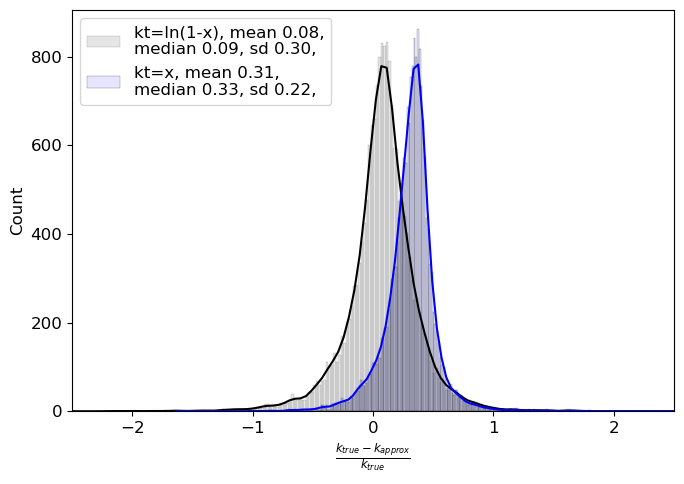

In [712]:
plt.figure(figsize=(7,5))
plt.rc("font",size=12)
# plt.subplot(1,2,1)

rd=(peptides.k-peptides.k_log_apr_noise)/peptides.k
sns.histplot(rd,kde=True,alpha=0.1,color='k',
             label="kt=ln(1-x)"+f", mean {np.mean(rd):.2f},\nmedian {np.nanmedian(rd):.2f}, sd {np.std(rd):.2f}, ")
# sns.histplot((peptides.k-peptides.k_two_samp_noise)/peptides.k,kde=False,label="kt=x",color='b',alpha=0.5)
plt.legend()
plt.xlabel(r"$\frac{k_{true} - k_{approx}}{k_{true}}$")
plt.xlim([-2,2])

# plt.subplot(1,2,2)
rd=(peptides.k-peptides.k_two_samp_noise)/peptides.k

# sns.histplot((peptides.k-peptides.k_log_apr_noise)/peptides.k,kde=False,label="kt=ln(1-x)",alpha=0.5,color='k')
sns.histplot(rd,kde=True,color='b',alpha=0.1,
             label="kt=x"+f", mean {np.mean(rd):.2f},\nmedian {np.nanmedian(rd):.2f}, sd {np.std(rd):.2f}, ")
plt.legend()
plt.xlabel(r"$\frac{k_{true} - k_{approx}}{k_{true}}$")
plt.xlim([-2.5,2.5])

plt.tight_layout()
plt.savefig(f"rate_Rd_{t}.jpeg",dpi=900)

In [689]:
# temp_data=peptides[(peptides.k<0.35/t)&(peptides.I0_t_d>0.031)]#[(peptides.k<0.35/t) &(peptides.I0_t_d>0.031)]
# print(temp_data.shape)

# plt.figure(figsize=(7,5))
# plt.rc("font",size=12)
# # plt.subplot(1,2,1)

# rd=(temp_data.k-temp_data.k_log_apr_noise)/temp_data.k
# sns.histplot(rd,kde=True,alpha=0.1,color='k',
#              label="kt=ln(1-x)"+f", mean {np.mean(rd):.2f},\nmedian {np.nanmedian(rd):.2f}, sd {np.std(rd):.2f}, ")
# # sns.histplot((temp_data.k-temp_data.k_two_samp_noise)/temp_data.k,kde=False,label="kt=x",color='b',alpha=0.5)
# plt.legend()
# plt.xlabel(r"$\frac{k_{true} - k_{approx}}{k_{true}}$")
# # plt.xlim([-2,2])

# # plt.subplot(1,2,2)
# rd=(temp_data.k-temp_data.k_two_samp_noise)/temp_data.k

# # sns.histplot((temp_data.k-temp_data.k_log_apr_noise)/temp_data.k,kde=False,label="kt=ln(1-x)",alpha=0.5,color='k')
# sns.histplot(rd,kde=True,color='b',alpha=0.1,
#              label="kt=x"+f", mean {np.mean(rd):.2f},\nmedian {np.nanmedian(rd):.2f}, sd {np.std(rd):.2f}, ")
# plt.legend()
# plt.xlabel(r"$\frac{k_{true} - k_{approx}}{k_{true}}$")
# # plt.xlim([-2.5,2.5])

# plt.tight_layout()
# plt.savefig(f"rate_Rd_{t}.jpeg",dpi=900)

# plt.tight_layout()
# plt.savefig(f"f_rate_Rd_{t}.jpeg",dpi=900)

In [690]:
# temp_data.iloc[100,:].k*t,temp_data.iloc[100,:].I0_t_d                       
# temp_data.iloc[100,:]

In [458]:
# # # peptides[['I0_t','I0_t_noise']]

# # plt.figure(figsize=(10,5))
# # plt.subplot(1,2,1)
# # sns.histplot((peptides.I0_t-peptides.I0_t_noise)/peptides.I0_t,kde=False,label="ln(1-x)",alpha=0.5,color='k') 
# # # plt.legend()
# # plt.xlabel(r"noise [rand.normal(meand=0,sd=0.5E-3)]")

# # plt.subplot(1,2,2)
# sns.histplot(peptides.I0_t_rd,color='green',alpha=0.4)
# plt.xlabel(r"$\frac{I_{0}(t)_{theo} - I_{0}(t)_{exp}}{I_{0}(t)_{theo}}$")

# plt.tight_layout()
# plt.savefig("addedNoise.jpeg",dpi=900)

In [459]:
# sns.histplot(peptides.k,kde=False,label="ln(1-x)",alpha=0.5,color='k')  
# plt.xlabel(r"turnover rates (k)")

# plt.tight_layout()
# plt.savefig("turnover_rates.jpeg",dpi=900)

In [273]:
# rd_log_apr_err=(peptides.k-peptides.k_log_apr_noise)/peptides.k
# plt.scatter(peptides.I0_t_rd,(peptides.k-peptides.k_log_apr_noise)/peptides.k,c='k',alpha=0.7)
# plt.vlines(x=0,ymin=min(rd_log_apr_err),ymax=max(rd_log_apr_err))
# plt.hlines(y=0,xmin=min(peptides.I0_t_rd),xmax=max(peptides.I0_t_rd))

In [ ]:
# rd_log_apr_err=(peptides.k-peptides.k_two_samp_noise)/peptides.k
# plt.scatter(peptides.I0_t_rd,(peptides.k-peptides.k_two_samp_noise)/peptides.k,c='k',alpha=0.7)
# plt.vlines(x=0,ymin=min(rd_log_apr_err),ymax=max(rd_log_apr_err))
# plt.hlines(y=0,xmin=min(peptides.I0_t_rd),xmax=max(peptides.I0_t_rd))